## Wing Kinematics

1. Create a figure (either in python, in a vector-based drawing program like inkscape or illustrator, or as a solidworks rendering) of your system kinematics. Annotate the image to include:

    - Names for each rotational reference frame. You will need one for each rigid body (that moves independently), as well as one for the Newtonian reference frame (N). Use the convention of a capital letter (A,B,C,…)
    - Labeled joint locations
    - A set of orthonormal basis vectors for each fram. It is best practice to align one of the basis vectors with each rigid link.
    - variable names for each state variable 
    - geometric constants such as link lengths

    Save this figure for reuse later. You will need to add mass and inertial information as well as system stiffness information, so make sure you do your work in a way that permits reusing and modifying the figure.

In [1]:
%matplotlib inline
import scipy.optimize
import pynamics
from pynamics.frame import Frame
from pynamics.variable_types import Differentiable,Constant
from pynamics.system import System
from pynamics.body import Body
from pynamics.dyadic import Dyadic
from pynamics.output import Output,PointsOutput
from pynamics.particle import Particle
import pynamics.integration
import numpy
import matplotlib.pyplot as plt
plt.ion()
from math import pi

In [2]:
system = System()
pynamics.set_system(__name__,system)

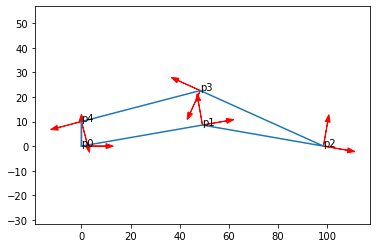

In [3]:
x = [0, 49.26, 98.52, 48.38, 0, 0]
y = [0, 8.57, 0, 22.61, 10, 0]
plt.plot(x,y)
plt.axis('equal')
for i in range(0, len(x)-1):
    plt.text(x[i], y[i], "p"+str(i))

alen = 10    
plt.arrow(0, 0, alen, 0,head_width=2,width=0.1,color='r')
plt.arrow(0, 0, 0, alen,head_width=2,width=0.1,color='r')
vx = []
vy = []
for i in range(1, len(x)-1):
    vecx = numpy.array([x[i]-x[i-1], y[i]-y[i-1]])
    vecx = vecx/(vecx.dot(vecx)**0.5)
    vecy = numpy.cross([0,0,1], vecx)[0:2]
    plt.arrow(x[i], y[i], alen*vecx[0], alen*vecx[1],head_width=2,width=0.1,color='r')
    plt.arrow(x[i], y[i], alen*vecy[0], alen*vecy[1],head_width=2,width=0.1,color='r')
    vx.append(vecx)
    vy.append(vecy)

2. Make the device in paper or cardboard. You need an up-to-date model if it has changed from your individual assignments. The paper model should dimensionally match your code.

![](paper%20wing%20reduce.jpeg)

3. Using a pynamics-based script, develop a kinematic model for your device. Following the triple pendulum example,

    1. Import packages

    2. Define variables and constants (you may want to add, remove, or rename variables to match your figure)
    
    3. Declare frames (you may need to add frames or rename them)

    4. Define frame rotations (you may want to switch the axis about which frames rotate)

    5. Compose kinematics (this depends entirely on the geometry of your system)

    6. Take time-derivatives of position vectors

    7. Assemble into a Jacobian that maps input velocities to output velocities.

In [4]:
lA = Constant(1,'lA',system)
lB = Constant(1,'lB',system)
lC = Constant(1,'lC',system)
lD = Constant(1,'lD',system)
lE = Constant(1,'lE',system)

mA = Constant(1,'mA',system)
mB = Constant(1,'mB',system)
mC = Constant(1,'mC',system)
mD = Constant(1,'mD',system)
mE = Constant(1,'mE',system)


g = Constant(9.81,'g',system)
# b = Constant(1e1,'b',system)
# k = Constant(1e1,'k',system)

# preload1 = Constant(0*pi/180,'preload1',system)
# preload2 = Constant(0*pi/180,'preload2',system)
# preload3 = Constant(0*pi/180,'preload3',system)

Ixx_A = Constant(1,'Ixx_A',system)
Iyy_A = Constant(1,'Iyy_A',system)
Izz_A = Constant(1,'Izz_A',system)
Ixx_B = Constant(1,'Ixx_B',system)
Iyy_B = Constant(1,'Iyy_B',system)
Izz_B = Constant(1,'Izz_B',system)
Ixx_C = Constant(1,'Ixx_C',system)
Iyy_C = Constant(1,'Iyy_C',system)
Izz_C = Constant(1,'Izz_C',system)
Ixx_D = Constant(1,'Ixx_D',system)
Iyy_D = Constant(1,'Iyy_D',system)
Izz_D = Constant(1,'Izz_D',system)
Ixx_E = Constant(1,'Ixx_E',system)
Iyy_E = Constant(1,'Iyy_E',system)
Izz_E = Constant(1,'Izz_E',system)

In [5]:
tol = 1e-12

In [6]:
tinitial = 0
tfinal = 10
fps = 30
tstep = 1/fps
t = numpy.r_[tinitial:tfinal:tstep]

In [7]:
qA,qA_d,qA_dd = Differentiable('qA',system)
qB,qB_d,qB_dd = Differentiable('qB',system)
qC,qC_d,qC_dd = Differentiable('qC',system)
qD,qD_d,qD_dd = Differentiable('qD',system)
qE,qE_d,qE_dd = Differentiable('qE',system)

In [8]:
initialvalues = {}
initialvalues[qA]=0*pi/180
initialvalues[qA_d]=0*pi/180
initialvalues[qB]=0*pi/180
initialvalues[qB_d]=0*pi/180
initialvalues[qC]=0*pi/180
initialvalues[qC_d]=0*pi/180
initialvalues[qD]=0*pi/180
initialvalues[qD_d]=0*pi/180
initialvalues[qE]=0*pi/180
initialvalues[qE_d]=0*pi/180

In [9]:
statevariables = system.get_state_variables()
ini = [initialvalues[item] for item in statevariables]

In [10]:
N = Frame('N')
A = Frame('A')
B = Frame('B')
C = Frame('C')
D = Frame('D')
E = Frame('E')

In [11]:
system.set_newtonian(N)

In [12]:
#if not global_q:
A.rotate_fixed_axis_directed(N,[0,0,1],qA,system)
B.rotate_fixed_axis_directed(A,[0,0,1],qB,system)
C.rotate_fixed_axis_directed(B,[0,0,1],qC,system)
D.rotate_fixed_axis_directed(C,[0,0,1],qD,system)
E.rotate_fixed_axis_directed(D,[0,0,1],qE,system)
#else:
    #A.rotate_fixed_axis_directed(N,[0,0,1],qA,system)
    #B.rotate_fixed_axis_directed(N,[0,0,1],qB,system)
    #C.rotate_fixed_axis_directed(N,[0,0,1],qC,system)
    #D.rotate_fixed_axis_directed(N,[0,0,1],qD,system)
    #E.rotate_fixed_axis_directed(N,[0,0,1],qE,system)

4. Select or Solve for a valid initial condition that represents the system in the middle of a typical gait, when it is both moving and when forces are being applied to it (or to the world by it)

    Despite the fact that you will be using a symbolic representation, you still need to solve for a valid initial condition if your device is a “parallel mechanism.” This may be done using a nonlinear solver such as scipy.optimize.minimize

In [13]:
dL1 = 50
dL2 = 50
dL3 = 55
dL4 = 50
dL5 = 10
dp0 = 0,0

dex = 90
dey = 0

In [14]:
def obj_fun(variables):

    x0,y0,x1,y1,x2,y2,x3,y3,x4,y4 = variables
    p0 = numpy.array([x0,y0])
    p1 = numpy.array([x1,y1])
    p2 = numpy.array([x2,y2])
    p3 = numpy.array([x3,y3])
    p4 = numpy.array([x4,y4])
    
    v0 = p0 - dp0
    v1 = p1 - p0
    v2 = p2 - p1
    v3 = p3 - p2
    v4 = p4 - p3
    v5 = p0 - p4
    
    L0 = (v0.dot(v0))**.5
    L1 = (v1.dot(v1))**.5
    L2 = (v2.dot(v2))**.5
    L3 = (v3.dot(v3))**.5
    L4 = (v4.dot(v4))**.5
    L5 = (v5.dot(v5))**.5
    
    error = []
    error.append(L1-dL1)
    error.append(L2-dL2)
    error.append(L3-dL3)
    error.append(L4-dL4)
    error.append(L5-dL5)
    error.append(L0)
    error.append(x4)
    
    # end effector
    error.append(x2-dex)
    error.append(y2-dey)
   
    error = numpy.array(error)
    error = (error.dot(error))**.5
    return error

In [15]:
ini = [0, 0, 50, 8, 100, 0, 50, 22, 0, 10]
result = scipy.optimize.minimize(obj_fun,ini)
print(result.fun)

5.535714777585825e-08


5. Plot the system in this position.

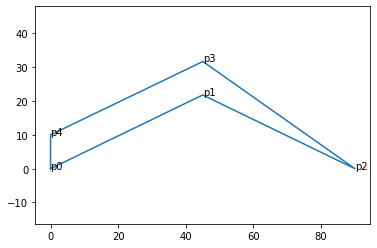

In [16]:
# plot
p = result.x.reshape((5,2))
plot_lines = numpy.concatenate((p,p[0:1]),0)
plt.plot(*(plot_lines.T))
plt.axis('equal')
for ii,item in enumerate(p):
    plt.text(item[0],item[1],'p'+str(ii))

6. From your biomechanics-based specifications, define one or more force vector estimates (one for each end effector) that the system should be expected to experience. Consider including, based on your research

    1. the force of gravity exerted by the mass of a “payload” or the main body of the robot.

    2. the acceleration the system experiences during a typical gait
    
    3. ground reaction forces measured from biomechanics studies.

7. Calculate the force or torque required at the input to satisfy the end-effector force requirements

8. Estimate the velocity of the end-effector in this configuration. Using the Jacobian, calculate the speed required by the input(s) to achieve that output motion.

    This may not be directly solvable based on your device kinematics; an iterative guess-and-check approach is ok.

9. Finally, using the two estimates about force and speed at the input, compute the required power in this configuration.